<img src="http://imgur.com/1ZcRyrc.png" style="float: left; margin: 20px; height: 55px">

# Project 3: Web APIs & NLP

---

Notebook 1: Data Collection and Export<br>
Notebook 2: Cleaning, Preprocessing and EDA<br>
**Notebook 3: Model Selection**
---

In [1]:
# Imports
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split, GridSearchCV, cross_val_score
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.naive_bayes import MultinomialNB
from sklearn.pipeline import Pipeline
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay, accuracy_score, plot_roc_curve, roc_auc_score, recall_score, precision_score, f1_score
from sklearn.ensemble import RandomForestClassifier

import warnings
#warnings.filterwarnings("ignore")

In [2]:
# Importing datasets from Notebook 2
combined = pd.read_csv('../datasets/combined.csv')

In [3]:
combined.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 29982 entries, 0 to 29981
Data columns (total 2 columns):
 #   Column       Non-Null Count  Dtype 
---  ------       --------------  ----- 
 0   subreddit    29982 non-null  object
 1   title_final  29940 non-null  object
dtypes: object(2)
memory usage: 468.6+ KB


In [4]:
# Dropping titles that became null values after stopwords were removed
combined = combined.dropna(axis=0)

In [5]:
print(f'There are {combined.isnull().sum().sum()} null values left in the dataset.')

There are 0 null values left in the dataset.


In [6]:
# Engineering a feature to turn subreddit into a 1/0 column, where 1 indicates PS5
combined['ps5'] = [1 if value == 'ps5' else 0 for value in combined['subreddit'].values]

In [7]:
combined['ps5'].value_counts()

1    14980
0    14960
Name: ps5, dtype: int64

In [8]:
# Dropping subreddit column
combined = combined[['ps5','title_final']]
print(combined.shape)
combined.head()

(29940, 2)


,ps5,title_final
0,1,yall get ps
1,1,p horizon bundle still stock p direct
2,1,p doesnt work
3,1,vrr support hdmi
4,1,slow download speed


## 1. Preparation

### 1.1 Train-Test Split

In [9]:
# Assigning X (feature matrix) and Y (response vector)
X = combined['title_final']
y = combined['ps5']

In [10]:
# Splitting the dataset
X_train, X_test, y_train, y_test = train_test_split(X, y, stratify=y, random_state = 42, test_size=0.1)

In [11]:
#looking at the shapes of the training and test data
print(X.shape)
print(X_train.shape)
print(X_test.shape)
print('')
print(y.shape)
print(y_train.shape)
print(y_test.shape)

(29940,)
(26946,)
(2994,)

(29940,)
(26946,)
(2994,)


### 1.2 Baseline


We need to calculate baseline accuracy in order to tell if our model is better than null model, (blindly predicting everything).

In [12]:
# Calculating percentage of each category
y_test.value_counts(normalize=True)

1    0.500334
0    0.499666
Name: ps5, dtype: float64

The success rate of blind classification is currently 50%

### 1.3 Creating a Modelling Functions

In [13]:
# Creating dictionary of Classification Models
mods = {'lr': LogisticRegression(max_iter = 1_000, random_state = 42),
        'rf': RandomForestClassifier(random_state = 42),
        'nb': MultinomialNB()}

In [14]:
# Creating function for Count Vectorizer
def cvec_model(mod):
    
    # Initiating a pipeline
    pipe = Pipeline([('cvec', CountVectorizer()), (mod, mods[mod])])

    # Setting up constant pipe parameters to ensure fair comparison
    pipe_params = {
        'cvec__max_features' : [5_000],
        'cvec__ngram_range' : [(1,1)]
    }

    # Instantiating a Gridsearch
    gs = GridSearchCV(pipe, 
                      param_grid=pipe_params, 
                      cv=5,
                      n_jobs=-1
                     )

    # Fitting
    gs.fit(X_train, y_train);

    print('CV Score:', gs.best_score_)
    print('Train Score:', gs.score(X_train, y_train)) 
    print('Test Score:', gs.score(X_test, y_test)) 
    print('\n')

    # Get predictions
    predictions = gs.predict(X_test)
    
    # Additional Metrics
    print('Recall:', recall_score(y_test, predictions))
    print('Precision:', precision_score(y_test, predictions))
    print('F1 Score', f1_score(y_test, predictions))
    print('ROC Score:',roc_auc_score(y_test, predictions))
    print('\n')

          
    # Plot confusion matrix
    cm = confusion_matrix(y_test, predictions)
    disp = ConfusionMatrixDisplay(confusion_matrix=cm)
    disp.plot(cmap = 'Blues')
    plt.show();

In [15]:
# Creating function for TF-IDF Vectorizer
def tvec_model(mod):
    
    # Initiating a pipeline
    pipe = Pipeline([('tvec', TfidfVectorizer()), (mod, mods[mod])])

    # Setting up constant pipe parameters to ensure fair comparison
    pipe_params = {
        'tvec__max_features' : [5_000],
        'tvec__ngram_range' : [(1,1)]
    }

    # Instantiating a Gridsearch
    gs = GridSearchCV(pipe, 
                      param_grid=pipe_params, 
                      cv=5,
                      n_jobs=-1
                     )

    # Fitting
    gs.fit(X_train, y_train);
    
    print('CV Score:', gs.best_score_)
    print('Train Score:', gs.score(X_train, y_train)) 
    print('Test Score:', gs.score(X_test, y_test))
    print('\n')

    # Get predictions
    predictions = gs.predict(X_test)

    # Additional Metrics
    print('Recall:', recall_score(y_test, predictions))
    print('Precision:', precision_score(y_test, predictions))
    print('F1 Score', f1_score(y_test, predictions))
    print('ROC Score:',roc_auc_score(y_test, predictions))
    print('\n')
    
    # Plot confusion matrix
    cm = confusion_matrix(y_test, predictions)
    disp = ConfusionMatrixDisplay(confusion_matrix=cm)
    disp.plot(cmap = 'Blues')
    plt.show();

---

## 2. Modelling

We will first look at a few combinations of vectorizers and classification models to identify the most suitable model for our dataset. Pipeline parameters will be kept at a constant for now to ensure fair comparison.

### 2.1 Naive Bayes + Count Vectorizer

CV Score: 0.7528016012828992
Train Score: 0.7967416314109701
Test Score: 0.7715430861723447


Recall: 0.732977303070761
Precision: 0.7945007235890015
F1 Score 0.7625000000000001
ROC Score: 0.7715688654391237




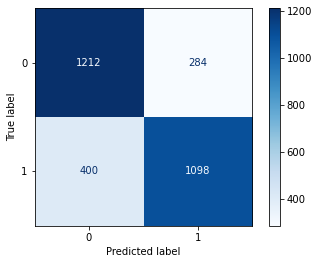

In [16]:
cvec_model('nb')

### 2.2 Naive Bayes + TF-IDF Vectorizer

CV Score: 0.7475317032462542
Train Score: 0.8003414235879166
Test Score: 0.7608550434201736


Recall: 0.719626168224299
Precision: 0.784570596797671
F1 Score 0.7506963788300837
ROC Score: 0.7608826028287271




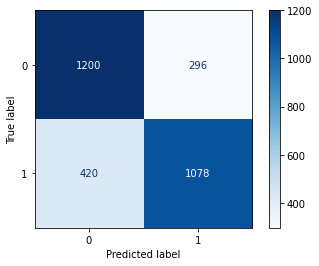

In [17]:
tvec_model('nb')

For Naive Bayes, Count Vectorizer gives higher scores across the board (except the training score). Testing scores are lower than training scores, which suggests overfitting.

### 2.3 Logistic Regression + Count Vectorizer

CV Score: 0.7654569691369522
Train Score: 0.8399762487938841
Test Score: 0.7745490981963928


Recall: 0.8204272363150867
Precision: 0.7516819571865443
F1 Score 0.7845515480370252
ROC Score: 0.774518430991768




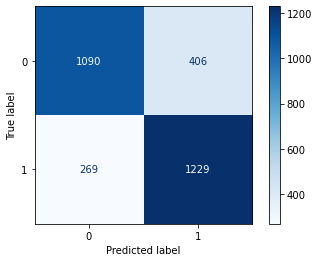

In [18]:
cvec_model('lr')

### 2.4 Logistic Regression + TF-IDF Vectorizer

CV Score: 0.7693165594313436
Train Score: 0.8273584205447932
Test Score: 0.7802271209084837


Recall: 0.8344459279038718
Precision: 0.7530120481927711
F1 Score 0.7916402786573781
ROC Score: 0.7801908783904385




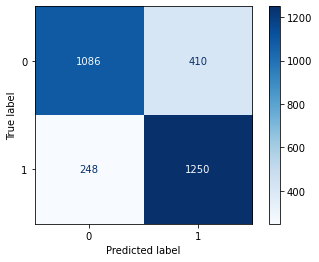

In [19]:
tvec_model('lr')

For Logistic Regression, TF-IDF Vectorizer gives slightly better scores than Count Vectorizer, other than training scores. Testing scores are lower than training scores, which suggests overfitting. Predictions were better for True Positives and False Negatives, but worse when it came to True Negatives and False Positives.

### 2.5 Random Forest + Count Vectorizer

CV Score: 0.7536553089833582
Train Score: 0.9768054627774067
Test Score: 0.760187040748163


Recall: 0.7590120160213618
Precision: 0.7610441767068273
F1 Score 0.7600267379679144
ROC Score: 0.760187826192499




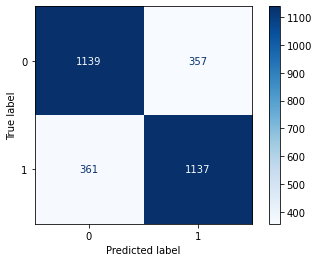

In [20]:
cvec_model('rf')

### 2.6 Random Forest + TF-IDF Vectorizer

CV Score: 0.7601869540474636
Train Score: 0.9767312402582944
Test Score: 0.7705410821643287


Recall: 0.8090787716955942
Precision: 0.7513949163050218
F1 Score 0.7791706846673095
ROC Score: 0.770515321676674




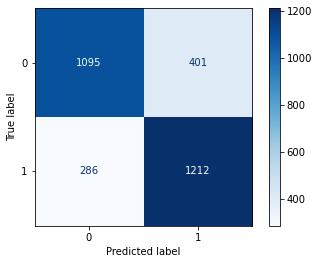

In [21]:
tvec_model('rf')

For Random Forest, scores for TF-IDF vectorizer were generally better, other than Precision. This is because there were more predictions that were True Positives and lesser predictions that were True Negatives. There was also a big difference in testing and training scores, which shows us that the model is moderately overfitted.

---

## 3. Hyperparameter Tuning

Next, we will try tuning the Naive Bayes and Logistic Regression models with their top scoring vectorizer. Random Forest will be dropped because of its overfitting.

### 3.1 Naive Bayes

CV Score: 0.7586651913418078
Train Score: 0.8184517182513175
Test Score: 0.7765531062124249
Best Parameters: ["{'cvec__max_df': 0.7, 'cvec__max_features': 10000, 'cvec__min_df': 2, 'cvec__ngram_range': (1, 2), 'nb__alpha': 1, 'nb__fit_prior': False}"]


Recall: 0.7409879839786382
Precision: 0.7979870596693026
F1 Score 0.7684319833852544
ROC Score: 0.7765768796898539




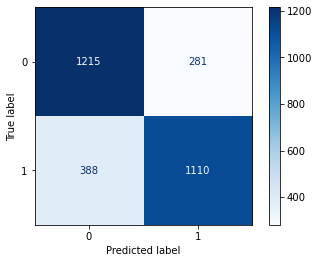

In [22]:
# Initiating a pipeline
pipe = Pipeline([
    ('cvec', CountVectorizer()),
    ('nb', MultinomialNB())
])

# Setting up pipe parameters
pipe_params = {
    'cvec__max_features' : [5_000, 10_000],
    'cvec__min_df' : [2, 3, 4],
    'cvec__max_df': [0.7, 0.8, 0.9],
    'cvec__ngram_range' : [(1,1), (1,2)],
    'nb__fit_prior': [True, False],
    'nb__alpha': [1, 2, 3, 4]
    
}

# Instantiating a Gridsearch
gs = GridSearchCV(pipe, 
                  param_grid=pipe_params, 
                  cv=5,
                  n_jobs=-1
                 )

# Fitting
gs.fit(X_train, y_train);

print('CV Score:', gs.best_score_)
print('Train Score:', gs.score(X_train, y_train)) 
print('Test Score:', gs.score(X_test, y_test)) 
print('Best Parameters:', [str(gs.best_params_)])
print('\n')

# Get predictions
predictions = gs.predict(X_test)

# Additional Metrics
print('Recall:', recall_score(y_test, predictions))
print('Precision:', precision_score(y_test, predictions))
print('F1 Score', f1_score(y_test, predictions))
print('ROC Score:',roc_auc_score(y_test, predictions))
print('\n')

# Plot confusion matrix
cm = confusion_matrix(y_test, predictions)
disp = ConfusionMatrixDisplay(confusion_matrix=cm)
disp.plot(cmap = 'Blues')
plt.show();

After the tuning, we can see that every score has increased when compared to before. True Postives and Negatives have both increased, False Positives and Negatives have both decreased.

### 3.2 Logistic Regression

- Using ElasticNet to add both a l1 or l2 penalty term, to determine which penalty term gives the best scores.

CV Score: 0.7735471728123426
Train Score: 0.8446151562384028
Test Score: 0.782565130260521
Best Parameters: ["{'lr__C': 1.0, 'lr__l1_ratio': 0.1, 'lr__penalty': 'elasticnet', 'lr__solver': 'saga', 'tvec__max_df': 0.7, 'tvec__max_features': 10000, 'tvec__min_df': 2, 'tvec__ngram_range': (1, 2)}"]


Recall: 0.8457943925233645
Precision: 0.7510373443983402
F1 Score 0.7956043956043956
ROC Score: 0.7825228647108802




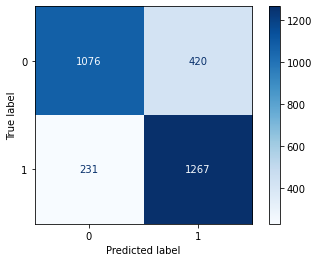

In [23]:
# Initiating a pipeline
pipe = Pipeline([
    ('tvec', TfidfVectorizer()),
    ('lr', LogisticRegression(random_state = 42, max_iter=1000))
])

# Setting up pipe parameters
pipe_params = {
    'tvec__max_features' : [10_000],
    'tvec__min_df' : [2],
    'tvec__max_df': [0.7],
    'tvec__ngram_range' : [(1,2)],
    'lr__C': np.linspace(0.001, 1, 10),
    'lr__solver': ['saga'],
    'lr__penalty': ['elasticnet'],
    'lr__l1_ratio': np.linspace(0, 1, 11)
}

# Instantiating a Gridsearch
gs = GridSearchCV(pipe, 
                  param_grid=pipe_params, 
                  cv=5,
                  n_jobs=-1
                 )

# Fitting
gs.fit(X_train, y_train);

print('CV Score:', gs.best_score_)
print('Train Score:', gs.score(X_train, y_train)) 
print('Test Score:', gs.score(X_test, y_test)) 
print('Best Parameters:', [str(gs.best_params_)])
print('\n')

# Get predictions
predictions = gs.predict(X_test)

# Additional Metrics
print('Recall:', recall_score(y_test, predictions))
print('Precision:', precision_score(y_test, predictions))
print('F1 Score', f1_score(y_test, predictions))
print('ROC Score:',roc_auc_score(y_test, predictions))
print('\n')

# Plot confusion matrix
cm = confusion_matrix(y_test, predictions)
disp = ConfusionMatrixDisplay(confusion_matrix=cm)
disp.plot(cmap = 'Blues')
plt.show();

The `l1_ratio` is the 0.1, the lowest value in the range passed in the GridSearch. This means that the l2 penalty term is at is maximum value. Hence, we can try using just a l2 penalty term to see if it will increase our model's accuracy.

CV Score: 0.7731760533292755
Train Score: 0.8454687152081942
Test Score: 0.7842351369405478
Best Parameters: ["{'lr__C': 0.9001, 'lr__solver': 'newton-cg', 'tvec__max_df': 0.7, 'tvec__max_features': 10000, 'tvec__min_df': 2, 'tvec__ngram_range': (1, 2)}"]


Recall: 0.8491321762349799
Precision: 0.75177304964539
F1 Score 0.7974921630094044
ROC Score: 0.7841917565666878




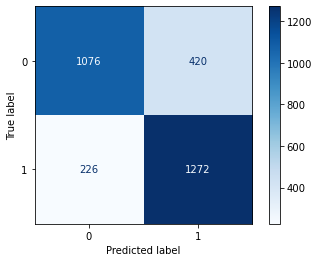

In [24]:
# Initiating a pipeline
pipe = Pipeline([
    ('tvec', TfidfVectorizer()),
    ('lr', LogisticRegression(random_state = 42, max_iter=1000))
])

# Setting up pipe parameters
pipe_params = {
    'tvec__max_features' : [5_000, 10_000],
    'tvec__min_df' : [2, 3, 4],
    'tvec__max_df': [0.7, 0.8, 0.9],
    'tvec__ngram_range' : [(1,1),(1,2)],
    'lr__C': np.linspace(0.001, 1, 11),
    'lr__solver': ['newton-cg', 'lbfgs', 'sag', 'saga']
}

# Instantiating a Gridsearch
gs = GridSearchCV(pipe, 
                  param_grid=pipe_params, 
                  cv=5,
                  n_jobs=-1
                 )

# Fitting
gs.fit(X_train, y_train);

print('CV Score:', gs.best_score_)
print('Train Score:', gs.score(X_train, y_train)) 
print('Test Score:', gs.score(X_test, y_test)) 
print('Best Parameters:', [str(gs.best_params_)])
print('\n')

# Get predictions
predictions = gs.predict(X_test)

# Additional Metrics
print('Recall:', recall_score(y_test, predictions))
print('Precision:', precision_score(y_test, predictions))
print('F1 Score', f1_score(y_test, predictions))
print('ROC Score:',roc_auc_score(y_test, predictions))
print('\n')

# Plot confusion matrix
cm = confusion_matrix(y_test, predictions)
disp = ConfusionMatrixDisplay(confusion_matrix=cm)
disp.plot(cmap = 'Blues')
plt.show();

Our model's scores have improved as expected after adding a l2 penalty term. This is the best scoring model thus far.

CV Score: 0.7672752611225162
Train Score: 0.8069843390484673
Test Score: 0.7735470941883767
Best Parameters: ["{'lr__C': 1.0, 'lr__penalty': 'l1', 'lr__solver': 'saga', 'tvec__max_df': 0.7, 'tvec__max_features': 10000, 'tvec__min_df': 3, 'tvec__ngram_range': (1, 2)}"]


Recall: 0.8671562082777036
Precision: 0.7305961754780652
F1 Score 0.793040293040293
ROC Score: 0.7734845212511513




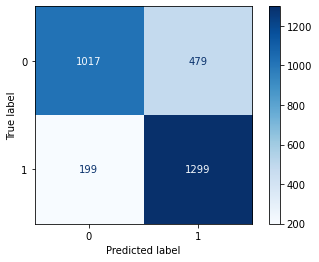

In [25]:
# Tuning a model which uses l1 penalty term to double check results

# Initiating a pipeline
pipe = Pipeline([
    ('tvec', TfidfVectorizer()),
    ('lr', LogisticRegression(random_state = 42, max_iter=1000))
])

# Setting up pipe parameters
pipe_params = {
    'tvec__max_features' : [5_000, 10_000],
    'tvec__min_df' : [2, 3],
    'tvec__max_df': [0.7, 0.8, 0.9],
    'tvec__ngram_range' : [(1,1), (1,2)],
    'lr__C': np.linspace(0.01, 1, 10),
    'lr__solver': ['saga'],
    'lr__penalty': ['l1']
}

# Instantiating a Gridsearch
gs = GridSearchCV(pipe, 
                  param_grid=pipe_params, 
                  cv=5,
                  n_jobs=-1
                 )

# Fitting
gs.fit(X_train, y_train);

print('CV Score:', gs.best_score_)
print('Train Score:', gs.score(X_train, y_train)) 
print('Test Score:', gs.score(X_test, y_test)) 
print('Best Parameters:', [str(gs.best_params_)])
print('\n')

# Get predictions
predictions = gs.predict(X_test)

# Additional Metrics
print('Recall:', recall_score(y_test, predictions))
print('Precision:', precision_score(y_test, predictions))
print('F1 Score', f1_score(y_test, predictions))
print('ROC Score:',roc_auc_score(y_test, predictions))
print('\n')

# Plot confusion matrix
cm = confusion_matrix(y_test, predictions)
disp = ConfusionMatrixDisplay(confusion_matrix=cm)
disp.plot(cmap = 'Blues')
plt.show();

After double checking out results, we can confirm that adding an l1 penalty term decreases the score.

---

## 4. Model Selection

First, lets initiate our best tuned model.

CV Score: 0.7731389406924227
Train Score: 0.8454687152081942
Test Score: 0.7842351369405478
Best Parameters: ["{'lr__C': 0.9, 'lr__solver': 'newton-cg', 'tvec__max_df': 0.7, 'tvec__max_features': 10000, 'tvec__min_df': 2, 'tvec__ngram_range': (1, 2)}"]


Recall: 0.8491321762349799
Precision: 0.75177304964539
F1 Score 0.7974921630094044
ROC Score: 0.7841917565666878




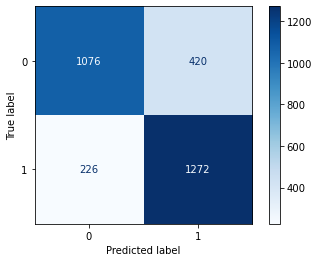

In [26]:
# Initiating a pipeline
pipe = Pipeline([
    ('tvec', TfidfVectorizer()),
    ('lr', LogisticRegression(random_state = 42, max_iter=1000))
])

# Setting up pipe parameters
pipe_params = {
    'tvec__max_features' : [10_000],
    'tvec__min_df' : [2],
    'tvec__max_df': [0.7],
    'tvec__ngram_range' : [(1,2)],
    'lr__C': [0.9],
    'lr__solver': ['newton-cg']
}

# Instantiating a Gridsearch
gs = GridSearchCV(pipe, 
                  param_grid=pipe_params, 
                  cv=5,
                  n_jobs=-1
                 )

# Fitting
gs.fit(X_train, y_train);

print('CV Score:', gs.best_score_)
print('Train Score:', gs.score(X_train, y_train)) 
print('Test Score:', gs.score(X_test, y_test)) 
print('Best Parameters:', [str(gs.best_params_)])
print('\n')

# Get predictions
predictions = gs.predict(X_test)

# Additional Metrics
print('Recall:', recall_score(y_test, predictions))
print('Precision:', precision_score(y_test, predictions))
print('F1 Score', f1_score(y_test, predictions))
print('ROC Score:',roc_auc_score(y_test, predictions))
print('\n')

# Plot confusion matrix
cm = confusion_matrix(y_test, predictions)
disp = ConfusionMatrixDisplay(confusion_matrix=cm)
disp.plot(cmap = 'Blues')
plt.show();

In [41]:
#Extracting the coefficients for the features in the model
coef = []
for x,y in zip(gs.best_estimator_[0].get_feature_names_out(), gs.best_estimator_[1].coef_.tolist()[0]):
    coef.append([x, y])
lr_coef = pd.DataFrame(coef, columns = ['Words', 'LR Coef'])

In [53]:
# Extracting top coefficients for PS5
ps5_coef = lr_coef.sort_values('LR Coef', ascending=False).head(15)

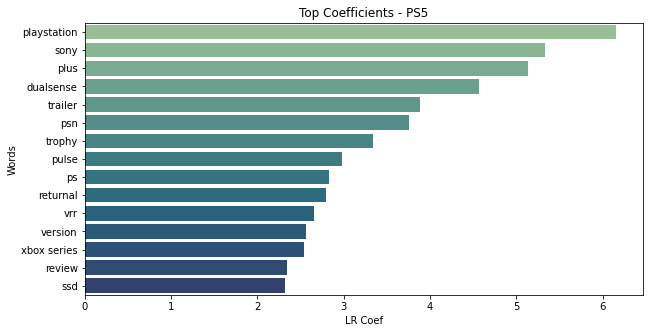

In [54]:
# Plotting barplot to visualize results
plt.figure(figsize = (10,5))
sns.barplot(x=ps5_coef['LR Coef'], y=ps5_coef['Words'], palette='crest').set(title='Top Coefficients - PS5');

The words with the highest coefficients are mostly brand specific, which makes sense as these words should mainly be in the PS5 subreddit.
<br><br>
A few examples are:
- `dualsense` : Dualsense controllers
- `psn` : PlayStation Network
- `pulse` : Pulse 3D wireless headset
- `returnal` : A PS5 exclusive game

It is interesting to see the words `xbox series` in this graph. This might be because of the high volume of posts comparing the two consoles on the PS5 subreddit. This also explains the slightly higher amount of false positives when compared to false negatives.

In [55]:
# Extracting top coefficients for Xbox
xbox_coef = lr_coef.sort_values('LR Coef', ascending=True).head(15)

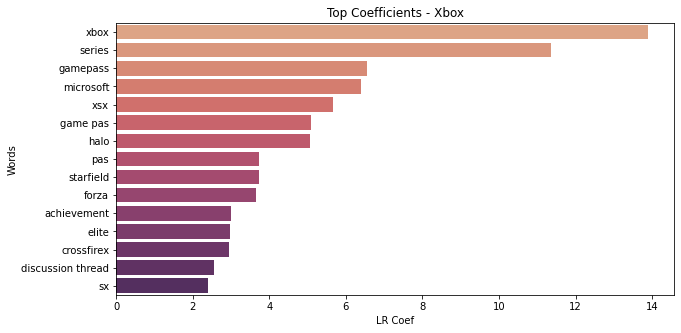

In [56]:
# Plotting barplot to visualize results
plt.figure(figsize = (10,5))
sns.barplot(x=-xbox_coef['LR Coef'], y=xbox_coef['Words'], palette='flare').set(title='Top Coefficients - Xbox');

The words with the highest coefficients are mostly brand specific too, similar to the ones for PS5.

A few examples are:

- `gamepass` : Game subcription service for Xbox
- `halo`, `starfield`, `forza`, `crossfirex`:  Xbox exclusive games
- `elite`: Elite wireless controllers


---

## 5. Conclusion

### 5.1 Insights

Our final model has a 78.4% rate of success of classifying a thread correctly. But, more can be done to increase the accuracy and hence the predictive strength of the model. 

Game store to focus more on trending topics/products identified:

- Console: PS5
- Game Titles(PS5): Elden Ring, Final Fantasy, Horizon Forbidden West, Gran Turismo
- Game Titles(Xbox): Elden Ring, Halo Infinite, Dying Light
- Hardware: Controllers

A possible expansion on this would be to identify emotions and sentiments on these topics, to ensure proper treatment.


### 5.2 Limitations

Our model might not be able to classify as accurately as required because both PS5 and Xbox are similar products. Both subreddits we used contain similar top words (i.e. `game`, `play`, `elden ring`), and we can expect the same results on other platforms.

Model selection wise, some of the limitations were mostly related to time and resource constraints whereby using a GridSearchCV with all the hyper parameters for tuning is not feasible. As such, some variations with better accuracy scores may have been missed out. We can explore the option of using Cloud GPUs to speed up processing times in the future.

Although Logistic regression is easily interpretable, it has some assumptions:
- Linearity between the features and the logit of the probability when Y=1
- Features are independent of each other

### 5.3 Possible Future Direction

- Further customize stopwords list, i.e. adding top few common words that appear in both subreddits
- Use autoML libraries to gain access to wider varieties of models
- Utilising cloud GPU services to speed up processing time
- Run sentiment and emotion analysis to gain further insights on trending topics.
- Automate the process so that frequent market analysis can be done in order to revise marketing strategies.

---